In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report
import xgboost as xgb


import sys 
sys.path.insert(0, "../")
from src.test import tests
from src.data import data
from src.models import models

In [2]:
pd.set_option('display.width', 5000) 
pd.set_option('display.max_colwidth', -1) 
pd.set_option('display.max_columns', 60)

In [98]:
interim_data_path  ="../data/interim/"
processed_data_path  ="../data/processed/"
model_path  ="../models/"

In [4]:
prod = pd.read_csv("{}2_explore_unit_correction___prod_before_unit_conversion.csv".format(interim_data_path))
deliv= pd.read_csv("{}2_explore_unit_correction___deliv_before_unit_conversion.csv".format(interim_data_path))
deliv['Date'] = pd.to_datetime(deliv['Date'])
systems = pd.read_csv("https://data.ca.gov/sites/default/files/Public%20Potable%20Water%20Systems%20FINAL%2006-22-2018_0.csv")

deliv_pivot = pd.read_csv("{}1_initial_eda___deliv.csv".format(interim_data_path))
deliv_pivot['Date'] = pd.to_datetime(deliv_pivot['Date'])
prod_pivot = pd.read_csv("{}1_initial_eda___prod.csv".format(interim_data_path))

deliv_gpcd_in_original = pd.read_csv("{}3_explore_gpcd___gpcdFromOriginalReport.csv".format(interim_data_path))
deliv_gpcd_in_original['Date'] = pd.to_datetime(deliv_gpcd_in_original['Date'])

In [5]:
############
# Drop records without units reported; we already know those are incorrect 
#################

In [6]:
noUnits = deliv[deliv['Delivered.Water.Units AS ORIGINALLY REPORTED']=="-"]

In [7]:
print(deliv.shape)
deliv = deliv[deliv['Delivered.Water.Units AS ORIGINALLY REPORTED']!="-"]
print(deliv.shape)

(78489, 34)
(75625, 34)


In [8]:
############
# Verify that we have one record per pwsid/date
#################

In [9]:
tests.test_verify_unique_rows(deliv)

In [10]:
# What % of records have units reported incorrectly?
deliv['original_units_incorrect'].value_counts() / deliv.shape[0]

0    0.958664
1    0.041336
Name: original_units_incorrect, dtype: float64

In [11]:
incorrectByYear = deliv[['Year','original_units_incorrect']].groupby('Year').agg({'original_units_incorrect':['sum','count']}).reset_index()
incorrectByYear['pct'] = incorrectByYear[('original_units_incorrect', 'sum')] / incorrectByYear[('original_units_incorrect', 'count')]
incorrectByYear

Year original_units_incorrect              pct
                             sum  count          
0  2013  630                      14873  0.042359
1  2014  588                      16080  0.036567
2  2015  1126                     21381  0.052664
3  2016  782                      23291  0.033575

In [12]:
############
# Create features: GPCD calculated from value in "WATER DELIVERIES Total.Delivered Residential IN REVISED UNITS", 
# but assume the value is in the original units
#################

In [13]:
print(deliv.shape)
deliv = deliv.merge(deliv_gpcd_in_original[['PWSID','Date','gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons','gpcd_numeric']].drop_duplicates(),
                   on = ['PWSID','Date'],
                   how="left")
print(deliv.shape)
predictors = ['gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons']

(75625, 34)
(75625, 36)


In [14]:
data.compare_correct_incorrect_values(deliv,'gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons')

,index,gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons_incorrect,gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons_correct
0,count,2.460000e+03,7.071900e+04
1,mean,inf,inf
2,std,NaN,NaN
3,min,5.996342e-05,-2.915576e+02
4,5%,4.510043e-04,1.904032e+00
5,10%,1.114041e-01,1.065000e+01
6,50%,1.396206e+04,9.691828e+01
7,90%,4.741685e+07,3.475924e+02
8,95%,1.579959e+08,6.110248e+02
9,max,inf,inf


In [15]:
############
# Create features: Population of Service Area
#################

In [16]:
predictors = predictors + ['Population Of Service Area',]

In [17]:
data.compare_correct_incorrect_values(deliv,'Population Of Service Area')

,index,Population Of Service Area_incorrect,Population Of Service Area_correct
0,count,3126.000000,7.161300e+04
1,mean,13430.112924,2.453112e+04
2,std,54398.497810,1.326244e+05
3,min,0.000000,0.000000e+00
4,5%,40.000000,2.500000e+01
5,10%,73.000000,4.500000e+01
6,50%,1000.000000,8.650000e+02
7,90%,29867.000000,5.699800e+04
8,95%,48165.000000,1.033400e+05
9,max,486189.000000,4.061504e+06


In [18]:
############
# Create features: Water System Classification
#################

In [19]:
deliv['Water.System.Classification'].value_counts(dropna=False)

Community Water System                                      32418
Large Water System                                          29787
Nontransient Noncommunity Water System                      6826 
Transient Noncommunity Water System                         5501 
NaN                                                         1018 
Local Government                                            33   
Privately owned, PUC-regulated, for profit water company    30   
Privately owned business (non-community)                    12   
Name: Water.System.Classification, dtype: int64

In [20]:
# Local Govt / Privately Owned have few records; all are correct
# Transient Noncommunity and Community Water are most likely to have incorrect units
deliv[['Water.System.Classification','original_units_incorrect']].groupby(['Water.System.Classification']).mean().reset_index().sort_values('original_units_incorrect')

,Water.System.Classification,original_units_incorrect
2,Local Government,0.000000
4,Privately owned business (non-community),0.000000
5,"Privately owned, PUC-regulated, for profit water company",0.000000
3,Nontransient Noncommunity Water System,0.008936
1,Large Water System,0.038977
0,Community Water System,0.047381
6,Transient Noncommunity Water System,0.065624


In [21]:
deliv['Water.System.Classification_mod'] = deliv['Water.System.Classification']
deliv.loc[pd.isnull(deliv['Water.System.Classification']),'Water.System.Classification_mod'] = "NA"
deliv.loc[deliv['Water.System.Classification_mod'].str.contains("Privately"),'Water.System.Classification_mod'] = "Private"

In [22]:
deliv,predictors = data.add_one_hot_encoding(deliv['Water.System.Classification_mod'],deliv,predictors)

In [23]:
############
# Create features: Original units reported
#################

In [24]:
# CCF is most likely to be incorrect
# AF is least likely to be incorrect
deliv[['Delivered.Water.Units AS ORIGINALLY REPORTED','original_units_incorrect']].groupby(['Delivered.Water.Units AS ORIGINALLY REPORTED']).mean().reset_index().sort_values('original_units_incorrect')

,Delivered.Water.Units AS ORIGINALLY REPORTED,original_units_incorrect
0,AF,0.017201
2,G,0.027247
3,MG,0.035810
1,CCF,0.073082


In [25]:
deliv,predictors = data.add_one_hot_encoding(deliv['Delivered.Water.Units AS ORIGINALLY REPORTED'],deliv,predictors)

In [26]:
############
# Create features: Institutional Service Connections
#################

In [27]:
# verify that we have one unique value for service connections per water system
uniqueInstServ = systems.groupby(['Water System No ']).agg({"Numer of Institutional Service Conections": lambda x: x.nunique()}).reset_index()
uniqueInstServ['Numer of Institutional Service Conections'].value_counts()

0.0    7492
1.0    395 
Name: Numer of Institutional Service Conections, dtype: int64

In [28]:
print(deliv.shape)
deliv = deliv.merge(systems[['Water System No ','Numer of Institutional Service Conections']].drop_duplicates(),
                   left_on = "PWSID",right_on = "Water System No ",how="left")
deliv = deliv.drop("Water System No ",axis=1)
print(deliv.shape)
predictors = predictors + ['Numer of Institutional Service Conections']

(75625, 48)
(75625, 49)


In [29]:
data.compare_correct_incorrect_values(deliv[(pd.isnull(deliv['Numer of Institutional Service Conections'])==False)],'Numer of Institutional Service Conections')

,index,Numer of Institutional Service Conections_incorrect,Numer of Institutional Service Conections_correct
0,count,219.000000,7953.000000
1,mean,38.246575,250.633723
2,std,88.939591,1557.963278
3,min,0.000000,0.000000
4,5%,0.000000,0.000000
5,10%,0.000000,1.000000
6,50%,1.000000,16.000000
7,90%,175.000000,311.000000
8,95%,348.000000,480.000000
9,max,348.000000,19197.000000


In [30]:
############
# Create features: Percent change from prior year
# Merge on original deliveries in gallons
#################

In [31]:
deliv['prior_year'] = deliv['Year']-1
print(deliv.shape)
deliv = deliv.merge(deliv[['Year','Month','PWSID',
                           'gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons']],
                    left_on=["prior_year",'Month','PWSID'],right_on=["Year",'Month','PWSID'],how="left",suffixes=['','_prior'])
print(deliv.shape)

(75625, 50)
(75625, 52)


In [32]:
deliv['change_from_prior'] = deliv['gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons_prior']-deliv['gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons']
deliv['pct_change'] = deliv['change_from_prior']/ deliv['gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons_prior']

In [33]:
predictors = predictors + ['pct_change']

In [34]:
data.compare_correct_incorrect_values(deliv[(pd.isnull(deliv['pct_change'])==False)],'pct_change')

,index,pct_change_incorrect,pct_change_correct
0,count,1519.000000,4.087300e+04
1,mean,-inf,-inf
2,std,NaN,NaN
3,min,-inf,-inf
4,5%,-1579.248040,-1.094135e+00
5,10%,-829.331549,-4.256844e-01
6,50%,0.012661,6.007487e-02
7,90%,0.998590,4.068299e-01
8,95%,0.999379,6.300680e-01
9,max,1.000000,2.946909e+03


### Split into train and test sets

In [35]:
train_pwsid, test_pwsid = models.gen_train_test_ids(deliv,'PWSID',seed=122,trainPercent=.8)
tests.verify_train_test_split(train_pwsid, test_pwsid)

In [36]:
deliv_train_X, deliv_test_X, xgb_train_X, xgb_test_X, xgb_train_y, xgb_test_y = models.generate_train_test_df_and_matrix(deliv,'PWSID',train_pwsid,test_pwsid,predictors,'original_units_incorrect')

In [37]:
models.review_train_test_split(deliv_train_X,deliv_test_X,'original_units_incorrect')

Train shape: (60480, 54)
Test shape: (15145, 54)
% incorrect in train: 0    0.961144
1    0.038856
Name: original_units_incorrect, dtype: float64
% incorrect in test: 0    0.948762
1    0.051238
Name: original_units_incorrect, dtype: float64


In [38]:
deliv_train_X[predictors+['original_units_incorrect',]].to_csv("{}4_unit_correction_model___train_2.csv".format(interim_data_path),index=False)
deliv_test_X[predictors+['original_units_incorrect',]].to_csv("{}4_unit_correction_model___test_2.csv".format(interim_data_path),index=False)

### Since each PWSID appears multiple times in the data set, perform a group split for CV to ensure that a unique PWSID cannot appear in both the train and test fold.

In [39]:
deliv_train_X = models.generate_cv_folds(deliv_train_X,train_pwsid,'PWSID',seed=122)

In [40]:
gss = GroupShuffleSplit(n_splits=4, test_size=0.25, random_state=0)

### Parameter Tuning

In [41]:
parameters = {'learning_rate': [0.01,0.05], #so called `eta` value
              'max_depth': [3,4,5,6],
              'min_child_weight': [1,3,5],
              'silent': [1],
              'n_estimators': [100,250], #number of trees
              'seed': [1337],
             'scale_pos_weight' :[float(np.sum(xgb_train_y == 0)) / np.sum(xgb_train_y == 1)]}

In [42]:
gbm = xgb.XGBClassifier(scale_pos_weight=float(np.sum(xgb_train_y == 0)) / np.sum(xgb_train_y == 1))

In [43]:
gsResults = models.gridsearch_best_precision_and_recall(gbm,parameters,gss,deliv_train_X,deliv,train_pwsid,'original_units_incorrect',xgb_train_X,xgb_test_X,xgb_train_y,xgb_test_y)

# Tuning hyper-parameters for precision

Fitting 4 folds for each of 48 candidates, totalling 192 fits
[CV] learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV] learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV] learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV] learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV] learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=   5.1s
[CV] learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=250, scale_pos_weight=24.7361702128, 

[CV] learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=   6.5s
[CV] learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=  16.6s
[CV] learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=   6.8s
[CV] learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  1.1min


[CV]  learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=  16.7s
[CV] learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=  16.4s
[CV] learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=  16.3s
[CV] learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=   6.5s
[CV] learning_rate=0.01, max_depth=4,

[CV] learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=  24.2s
[CV] learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=  23.8s
[CV] learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=  20.4s
[CV] learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=5, min_child_wei

[CV]  learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=   5.3s
[CV] learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=   5.2s
[CV] learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=  19.3s
[CV] learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=  21.4s
[CV] learning_rate=0.05, max_depth=3,

[CV] learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=   5.9s
[CV] learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=   6.1s
[CV] learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=  15.6s
[CV] learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=4, min_child_wei

[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  6.5min


[CV]  learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=  19.6s
[CV] learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=  19.7s
[CV] learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=   9.7s
[CV] learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=   9.6s
[CV] learning_rate=0.05, max_depth=5,

[CV] learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=  22.5s
[CV] learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=   9.7s
[CV] learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=  22.9s
[CV] learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=6, min_child_wei

[Parallel(n_jobs=5)]: Done 192 out of 192 | elapsed:  8.7min finished


Best parameters set found on development set:

{'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 250, 'scale_pos_weight': 24.736170212765959, 'seed': 1337, 'silent': 1}

Grid scores on development set:

0.978 (+/-0.000) for {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'scale_pos_weight': 24.736170212765959, 'seed': 1337, 'silent': 1}

0.978 (+/-0.000) for {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 250, 'scale_pos_weight': 24.736170212765959, 'seed': 1337, 'silent': 1}

0.978 (+/-0.000) for {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'scale_pos_weight': 24.736170212765959, 'seed': 1337, 'silent': 1}

0.978 (+/-0.000) for {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 250, 'scale_pos_weight': 24.736170212765959, 'seed': 1337, 'silent': 1}

0.978 (+/-0.000) for {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weig

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Fitting 4 folds for each of 48 candidates, totalling 192 fits
[CV] learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV] learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV] learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV] learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV] learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=   4.9s
[CV]  learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=   4.8s
[CV] 

[CV] learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=   8.8s
[CV] learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=  21.5s
[CV] learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=   8.4s
[CV] learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  1.2min


[CV]  learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=  21.6s
[CV] learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=  21.2s
[CV] learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=  20.9s
[CV] learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=   8.3s
[CV] learning_rate=0.01, max_depth=4,

[CV] learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=  18.5s
[CV] learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=  18.9s
[CV] learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=  17.0s
[CV] learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=5, min_child_wei

[CV]  learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=   4.4s
[CV] learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=   4.8s
[CV] learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=  20.8s
[CV] learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=  18.2s
[CV] learning_rate=0.05, max_depth=3,

[CV] learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=   5.9s
[CV] learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=   7.2s
[CV] learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=  15.9s
[CV] learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=4, min_child_wei

[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  6.1min


[CV]  learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=  18.1s
[CV] learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=  17.6s
[CV] learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=   6.5s
[CV] learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=   6.5s
[CV] learning_rate=0.05, max_depth=5,

[CV] learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=  21.4s
[CV] learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=100, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=   8.3s
[CV] learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1, total=  21.0s
[CV] learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=250, scale_pos_weight=24.7361702128, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=6, min_child_wei

[Parallel(n_jobs=5)]: Done 192 out of 192 | elapsed:  8.2min finished


Best parameters set found on development set:

{'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 250, 'scale_pos_weight': 24.736170212765959, 'seed': 1337, 'silent': 1}

Grid scores on development set:

0.955 (+/-0.002) for {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'scale_pos_weight': 24.736170212765959, 'seed': 1337, 'silent': 1}

0.952 (+/-0.001) for {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 250, 'scale_pos_weight': 24.736170212765959, 'seed': 1337, 'silent': 1}

0.955 (+/-0.002) for {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'scale_pos_weight': 24.736170212765959, 'seed': 1337, 'silent': 1}

0.952 (+/-0.001) for {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 250, 'scale_pos_weight': 24.736170212765959, 'seed': 1337, 'silent': 1}

0.955 (+/-0.002) for {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weig

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


### Fit model with best parameters

In [100]:
gbm = gsResults[1].best_estimator_
predictions = gbm.predict(xgb_test_X)
gbm.save_model('{}model_2.model'.format(model_path))

In [148]:
friendlyNames = {"gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons":"GPCD, from self-reported units and values",
                'Population Of Service Area': 'Population Of Service Area',
                'Community Water System': 'System Classification: Community',
                'Large Water System': 'System Classification: Large',
                'Local Government': 'System Classification: Local Goverment',
                'NA': 'System Classification: N/A',
                'Nontransient Noncommunity Water System': 'System Classification: Nontransient Noncommunity',
                'Private': 'System Classification: Private',
                'Transient Noncommunity Water System': 'System Classification: Transient Noncommunity',
                'AF': 'Original Units: AF',
                 'CCF': 'Original Units: CCF',
                 'G': 'Original Units: G',
                 'MG': 'Original Units: MG',
                 'Numer of Institutional Service Conections': '# Institutional Service Connections',
                 'pct_change': "YoY % Change in Water System's GPCD"
                }
friendlyNamesDF = pd.DataFrame.from_dict(friendlyNames,orient="index").reset_index()
friendlyNamesDF.columns=["predictors","pred_friendly_name"]

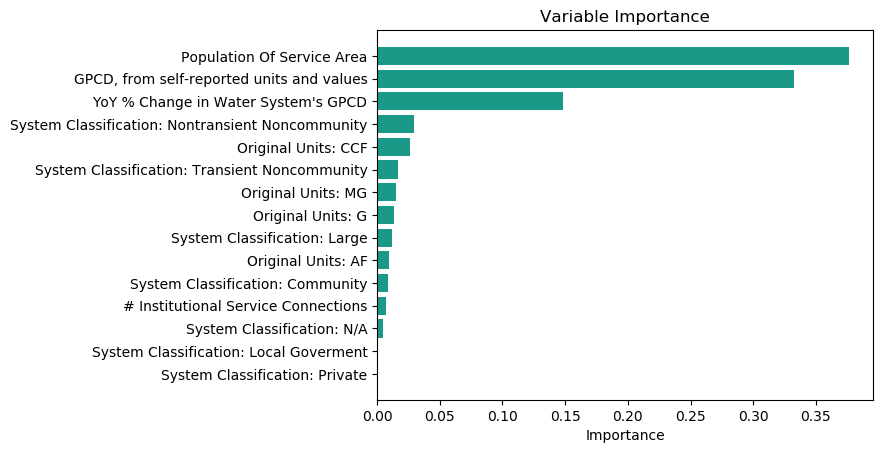

In [149]:
plt.rcdefaults()
fig, ax = plt.subplots()
varImp = pd.DataFrame({"predictors": predictors,
                      "imp": gbm.feature_importances_})
varImp = varImp.sort_values('imp',ascending=False)
varImp["y_pos"] = np.arange(len(predictors))
varImp = varImp.merge(friendlyNamesDF,on="predictors")
ax.barh(varImp['y_pos'],varImp['imp'], align='center',
        color='#1a9988', ecolor='black')

ax.set_yticks(y_pos)
ax.set_yticklabels(varImp['pred_friendly_name'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Importance')
ax.set_title('Variable Importance')

plt.show()

### Explore precision/recall

In [46]:
print(classification_report(xgb_test_y, gbm.predict(xgb_test_X)))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99     14369
          1       0.91      0.82      0.86       776

avg / total       0.99      0.99      0.99     15145



In [79]:
precisionRecall_test = models.get_precision_recall(gbm,xgb_test_y,xgb_test_X,beta=2)
print("Test: Precision / Recall with Best Threshold")
print(precisionRecall_test[precisionRecall_test['fl_beta']==max(precisionRecall_test['fl_beta'])])
print()
print()
precisionRecall_train = models.get_precision_recall(gbm,xgb_train_y,xgb_train_X,beta=2)
print("Train: Precision / Recall with Best Threshold")
print(precisionRecall_train[precisionRecall_train['fl_beta']==max(precisionRecall_train['fl_beta'])])


Test: Precision / Recall with Best Threshold
      precision    recall  threshold       fl   fl_beta
1411  0.754545   0.962629  0.055636   0.84598  0.912311


Train: Precision / Recall with Best Threshold
   precision    recall  threshold        fl   fl_beta
5  0.973477   0.999574  0.793466   0.986353  0.994244


### Apply best threshold

In [80]:
probs = pd.DataFrame(gbm.predict_proba(xgb_test_X))
probs['classification'] = probs[1].apply(lambda x: 1 if x > precisionRecall_train[precisionRecall_train['fl_beta']==max(precisionRecall_train['fl_beta'])]['threshold'].values[0] else 0)

In [81]:
print(classification_report(xgb_test_y,probs['classification']))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99     14369
          1       0.95      0.79      0.86       776

avg / total       0.99      0.99      0.99     15145



### Export predictions and actuals

In [89]:
deliv['model_prob'] = pd.DataFrame(gbm.predict_proba(deliv[predictors].as_matrix()))[0]
deliv['classification'] = deliv['model_prob'].apply(lambda x: 1 if x > precisionRecall_train[precisionRecall_train['fl_beta']==max(precisionRecall_train['fl_beta'])]['threshold'].values[0] else 0)

In [97]:
deliv[predictors+['original_units_incorrect','model_prob','classification','PWSID','Water.System.Name','Date']].to_csv('{}4_unit_correction_model___modelPred.csv'.format(processed_data_path),index=False)